# OISST Timeseries - NELME Regions

**ABOUT:**
Now that there exist climatologies and anomalies from those climate means the last product is then an application of those approaches, but within the scope of a specific area. For these we want to know what the average temperature was across a specific group of pixels defined by a polygon of interest. From those regional climatologies we can get timelines of temperature anomalies, their variance, and their likelihood with a regional scope.

## Product 4. OISST Regional Timeseries


**Objective: Calculate full sea surface temperature histories for the NMFS trawl regions**
 * Gulf of Maine
 * SNE + Mid-Atlantic Bight 
 * Northeast US LME

In [2]:
# Load Packages
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import os
import geopandas as gpd
import regionmask
import math
import oisstools as ot

# Set the workspace - local/ docker
workspace = "local"

# Root paths
root_locations = {"local"  : "/Users/akemberling/Box/",
                  "docker" : "/home/jovyan/"}


# Set root
box_root = root_locations[workspace]
print(f"Working via {workspace} directory at: {box_root}")


Working via local directory at: /Users/akemberling/Box/


## Step 1: Load the NMFS Regions

The following regions are composites of various strata from the [Northeast Groundfish Trawl Survey](https://www.fisheries.noaa.gov/region/new-england-mid-atlantic)

The region shapes being loaded were created in R using the following allocations:

"Southern New England"  = strata 01:12   
"Georges Bank"          = strata 13:23   
"Gulf of Maine"         = strata 24:40   
"Mid-Atlantic Bight"    = strata 61:76   

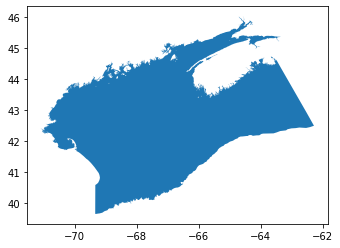

In [3]:
# Load trawl regions - created in R code
trawl_area_paths = {
    "Gulf of Maine"                                : f"{box_root}RES_Data/Shapefiles/NELME_regions/GoM_sf.shp",
    "Southern New England and Mid-Atlantic Bight"  : f"{box_root}RES_Data/Shapefiles/NELME_regions/SNEandMAB_sf.shp",
    "Northeastern US Shelf"                        : f"{box_root}RES_Data/Shapefiles/NELME_regions/NELME_sf.shp"}

# Format the lookup table
area_info = pd.DataFrame.from_dict(trawl_area_paths, orient = "index", columns = ["path"])
area_info = area_info.reset_index().rename(columns = {"index": "area"})

# Load polygons
research_areas = []
for i, area_path in area_info.iterrows():
    shape = gpd.read_file(area_path.path)
    research_areas.append(shape)

# Plot a single area - Georges Bank
research_areas[0].plot()

## Step 2: Load OISST Collection

Timelines for these area haven't been calculates yet so it should be possible to do the full thing all at once. Steps are to load the observed data, get what the mean sst is for every day as a timeseries, as well as what the climatology is for that day of the year.

In [4]:
# Set years
start_year = 1981
end_year = 2021

# Load paths together
fpaths = []
for yr in range(start_year, end_year + 1):
    fpaths.append(f'{box_root}RES_Data/OISST/oisst_mainstays/annual_observations/sst.day.mean.{yr}.v2.nc')

# Lazy-load the data itself using xr.open_mfdataset
oisst = xr.open_mfdataset(fpaths, combine = "by_coords", parallel = False)


# modified ordinal day function moved to oisstools module for consistency across notebooks
oisst = ot.add_mod(oisst, 'time')
oisst


,Array,Chunk
Bytes,59.85 GB,1.52 GB
Shape,"(14431, 720, 1440)","(366, 720, 1440)"
Count,123 Tasks,41 Chunks
Type,float32,numpy.ndarray


## Step 3: Load OISST Climatology

From the global extent climatology we will want to get regional means for the areas of interest.

In [5]:
oisst_clim = xr.open_dataset(f'{box_root}RES_Data/OISST/oisst_mainstays/daily_climatologies/daily_clims_1982to2011.nc')

## Step 4: Create Masked Timeseries

So the steps to create a masked timeseries are straightforward. Once everything is prepped you simply create a mask with the geometry of the polygon of interest. You then extract the cells that fall within it, and calculatet the mean temperature and standard deviation for the area for each time step. These steps are repeated for the raw observations as well as the climate means in order to get anomalies from the 82-2011 climatology.

In [ ]:
# Global Settings:
grid_ds  = oisst
clim_ds  = oisst_clim
var_name = "sst"

# list to store them un-appended
new_ts = []

##### loop through all the areas's  ####
for i, area in area_info.iterrows():
    
    
    # Grab the shape object the we are looping through
    shp_obj   = research_areas[i] 
    shp_name  = area["area"]
    poly_name = area["area"].replace("-", "_").replace(" ", "_").replace("___", "_").lower()  
    
    
    
    ##
    # 1. Calculate Mu and Sigma from climatology for area within polygon
    ##

    # a. Set up naming convention for var of interest
    clim_name = f"{var_name}_clim"
    sd_name   = f"clim_sd"

    # b. Make the mask
    area_mask = regionmask.Regions(shp_obj.geometry,
                                   name = shp_name)

    # c. Mask the array to get nan test
    mask = area_mask.mask(clim_ds, lon_name = "lon", lat_name = "lat")

    # d. Extract data that falls within the mask
    masked_ds = clim_ds.where(~np.isnan(mask))

    # e. Calculate timeseries mean and sd
    masked_ts               = getattr(masked_ds, var_name).mean(dim = ("lat", "lon"))#
    masked_ts[f"{sd_name}"] = getattr(masked_ds, var_name).std(dim = ("lat", "lon"))


    # f. Format masked timeseries dataframe
    regional_climatology = masked_ts.to_dataframe()
    regional_climatology = regional_climatology.reset_index()
    regional_climatology = regional_climatology.rename(columns = {f"{var_name}" : f"{clim_name}"})
    


    ##
    # 2. Calculate Mean Var Timeline from Observed Data for Area Within Polygon
    ##


    # a. Make the mask
    area_mask = regionmask.Regions(shp_obj.geometry,
                                   name = shp_name)

    # b. Mask the array with gom_mask to get nan test
    mask = area_mask.mask(grid_ds, lon_name = "lon", lat_name = "lat")

    # c. Extract data that falls within the mask
    masked_ds = grid_ds.where(~np.isnan(mask))

    # d. Calculate timeseries mean and sd
    masked_ts = getattr(masked_ds, var_name).mean(dim = ("lat", "lon"))


    # e. Masked Timeseries Dataframe
    regional_means = masked_ts.to_dataframe()
    regional_means = regional_means.reset_index()
    regional_means["time"] = pd.to_datetime(regional_means["time"])



    ##
    # 3. Log-Likelihood Estimate
    ##

    # Merge on MOD
    anom_timeline = regional_means.merge(regional_climatology, how = "left", on = "modified_ordinal_day")

    #Set index as the date
    anom_timeline.index = anom_timeline.index = anom_timeline["time"]
    anom_timeline = anom_timeline.drop(["time"], axis = 1)

    #Calc anoms
    anom_timeline = anom_timeline.assign(anom = anom_timeline[f"{var_name}"] - anom_timeline[f"{clim_name}"])
    anom_timeline = anom_timeline.rename(columns = { "anom" : f"{var_name}_anom"})
    
    # Get log likelihood Function
    def calc_ll(row):
        # log likelihood 
        n = 1
        anom  = row[f"{var_name}"]
        sigma = row["clim_sd"]
        mu    = row[f"{clim_name}"]
        log_lik = n * math.log(2 * math.pi * (sigma ** 2)) / 2 + np.sum(((anom - mu) ** 2) / (2 * (sigma ** 2)))
        return log_lik


    # Apply log likelihood
    anom_timeline["log_lik"] = anom_timeline.apply(calc_ll, axis = 1)
    anom_timeline = anom_timeline.reset_index()
    
    # re-order columns for peace of mind
    anom_timeline = anom_timeline[["time", "modified_ordinal_day", "sst", "sst_clim", "sst_anom", "clim_sd", "log_lik"]]
    
    # add to list
    new_ts.append(anom_timeline)

## Validation: Table inspection and Plot

In [1]:
new_ts[0].tail()

NameError: name 'new_ts' is not defined

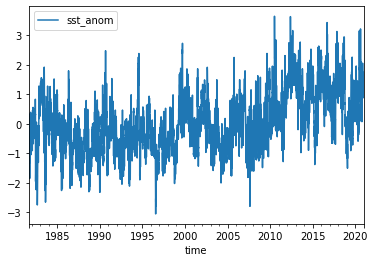

In [9]:
new_ts[0].plot("time", "sst_anom")

## Step 5: Export

In [10]:
# Information Constants

# Timeseries destination folder
out_folder = f"{box_root}RES_Data/OISST/oisst_mainstays/regional_timeseries/NELME_regions"

# Anomaly grid name
grid_name = "OISSTv2_anom"


##### Loop through all the areas  ####
for i, area in area_info.iterrows():
    
    # naming convention from sct.regional_anom_likelihoods
    mask_name = area["area"].replace("-", "_").replace(" ", "_").replace("___", "_").lower()   
    
    # Path to the timeseries
    out_path = f"{out_folder}/{grid_name}_{mask_name}.csv"
    
    # And export
    new_ts[i].to_csv(out_path, index = False)